# Lac Pavin phage db prep

In [1]:
import matplotlib, re, os, glob, datetime, difflib, random, time, math, json, wget
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO, SeqUtils, SearchIO

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

In [3]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"

# phage prediction

### define assemblies

In [4]:
# define samples/assemblies of interest
assemblies = {"water_column":[], "sediment":[]}
for assembly in glob.glob(rootdir.replace("analysis/", "QB3*/assembly.d/*/*megahit*/*min1000.fa")):
    if ("Creux" not in assembly) and ("ALN" not in assembly):
        if "SED" in assembly:
            assemblies["sediment"].append(assembly)
        else: assemblies["water_column"].append(assembly)

In [5]:
# build scaf len dict
scaflens = {}

for biome in assemblies:
    for assembly in assemblies[biome]:
        name = os.path.basename(assembly).split("_scaffold")[0]
        for record in SeqIO.parse(open(assembly), "fasta"):
            if name not in scaflens:
                scaflens[name] = {record.description.split(" ")[0]: len(record.seq)}
            else:
                scaflens[name][record.description.split(" ")[0]] = len(record.seq)

### run vibrant

In [ ]:
cmdir(rootdir + "viral")
cmdir(rootdir + "viral/vibrant/")

In [13]:
with open(rootdir + "scripts/runVibrant.sh", "w") as outfile:
    for assembly in assemblies:
        acode = "A" + "".join(os.path.basename(assembly).split("_")[1:3])
        call = "sbatch -J " + acode + " --wrap '/shared/software/vibrant/latest/bin/VIBRANT_run.py -i " + \
            assembly + " -t 48 -folder " + rootdir + "viral/vibrant/" + "'"
        outfile.write(call + "\n")

In [6]:
# grab summary files

gquality = []
paths = [rootdir + "/viral/vibrant/*/*/*genome_quality*",
        rootdir + "/viral/vibrant/*genome_quality*"]

for path in paths:
    for file in glob.glob(path):
        gquality.append(file)

In [7]:
# grab fna files for scaflen
vdna = []
paths = [rootdir + "/viral/vibrant/*/*/*_combined.fna",
        rootdir + "/viral/vibrant/*_combined.fna"]

for path in paths:
    for file in glob.glob(path):
        vdna.append(file)

# build lookup
vlens = {}
for fasta in vdna:
    for record in SeqIO.parse(open(fasta), "fasta"):
        vlens[record.description] = len(str(record.seq))

In [8]:
vib = pd.concat([pd.read_csv(file, sep="\t") for file in gquality])
vib["scafclean"] = vib["scaffold"].apply(lambda x: x.split(" ")[0])
vib["fragment"] = vib["scaffold"].apply(lambda x: "".join(x.split("_")[-2:]) if "fragment" in x else "None")
vib["length"] = vib["scaffold"].map(vlens)
vibsub = vib[["scafclean", "fragment", "scaffold", "type", "Quality", "length"]].query("length>5000")
vibsub.columns = ["scaffold", "fragment", "original_scaffold", "type", "quality", "length"]
# get rid of weird duplicates
vibsub = vibsub.drop_duplicates(["original_scaffold"])
vibsub.head()

,scaffold,fragment,original_scaffold,type,quality,length
1,LacPavin_0920_WC70_scaffold_1823591,None,LacPavin_0920_WC70_scaffold_1823591 read_lengt...,lysogenic,low quality draft,10033
4,LacPavin_0920_WC70_scaffold_1497187,None,LacPavin_0920_WC70_scaffold_1497187 read_lengt...,lytic,low quality draft,9465
5,LacPavin_0920_WC70_scaffold_117641,None,LacPavin_0920_WC70_scaffold_117641 read_length...,lytic,low quality draft,8078
8,LacPavin_0920_WC70_scaffold_811358,None,LacPavin_0920_WC70_scaffold_811358 read_length...,lytic,low quality draft,17965
9,LacPavin_0920_WC70_scaffold_189631,None,LacPavin_0920_WC70_scaffold_189631 read_length...,lytic,low quality draft,16307


### run virsorter

In [24]:
cmdir(rootdir + "viral/virsorter")

In [34]:
wrapper = open(rootdir + "viral/virsorter/wrapper.sh", "w")

for biome in assemblies:
    
    for assembly in assemblies[biome]:
        
        outdir = rootdir + "viral/virsorter/" + \
            os.path.basename(assembly).split("_scaf")[0]
        #cmdir(outdir)
        call = "sbatch --wrap '/shared/software/virsorter2/latest/container/virsorter2.sif " + \
            "run --keep-original-seq -i " + assembly + " -w " + outdir + \
            " --db-dir " + rootdir + "viral/virsorter/vs2-db/ " + \
                " --include-groups dsDNAphage,ssDNA --min-length 5000 --min-score 0.5 -j 48 all'"
        wrapper.write(call + "\n")

wrapper.close()

In [9]:
vir = pd.concat(pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "viral/virsorter/*/final-viral-score.tsv"))
vir["scaffold"] = vir["seqname"].apply(lambda x: x.split("||")[0])
vir["fragment"] = vir["seqname"].apply(lambda x: x.split("||")[1] if "full" not in x else "None")
virsub = vir[["scaffold", "fragment", "max_score", "max_score_group", "length"]].query("max_score>=0.9")
virsub.columns = ["scaffold", "fragment", "vs_score", "vs_group", "length"]
virsub.head()

,scaffold,fragment,vs_score,vs_group,length
1,LacPavin_0419_WC70S_scaffold_9116,None,0.953,dsDNAphage,11414
2,LacPavin_0419_WC70S_scaffold_21632,None,0.940,dsDNAphage,8702
3,LacPavin_0419_WC70S_scaffold_23585,None,0.987,dsDNAphage,37969
4,LacPavin_0419_WC70S_scaffold_31921,None,0.987,dsDNAphage,15226
6,LacPavin_0419_WC70S_scaffold_49979,None,0.993,dsDNAphage,39183


### integrate

In [10]:
vibset = set(vibsub["scaffold"])
virset = set(virsub["scaffold"])
mset = vibset.union(virset)
mlist = defaultdict(list)

for scaf in list(mset):
    
    ## determine source
    if (scaf in vibset) and (scaf not in virset):
        source = "vibrant"
    
    elif (scaf in virset) and (scaf not in vibset):
        source = "virsorter"
        
    else: source = "both"
    
    sample = "_".join(scaf.split("_")[0:3])
    mlist["scaffold"].append(scaf)
    mlist["sample"].append(sample)
    mlist["source"].append(source)
    mlist["scaffold_length"].append(scaflens[sample][scaf])
    
mdf = pd.DataFrame(mlist)

In [11]:
mdf.head()

,scaffold,sample,source,scaffold_length
0,LacPavin_0419_WC53_scaffold_20050,LacPavin_0419_WC53,both,32549
1,LacPavin_0920_WC12_scaffold_201813,LacPavin_0920_WC12,both,6884
2,LacPavin_0419_WC53_scaffold_363029,LacPavin_0419_WC53,both,9631
3,LacPavin_0818_WC55_scaffold_109062,LacPavin_0818_WC55,both,12965
4,LacPavin_0920_SED3_scaffold_996967,LacPavin_0920_SED3,both,9359


# clean

In [450]:
cmdir(rootdir + "/viral/genomes")

### write out prelim

In [468]:
# write out all sequences
sequence_dict = {}

for biome in assemblies:
    for sample in assemblies[biome]:
        for record in SeqIO.parse(open(sample), "fasta"):
            sequence_dict[record.description.split(" ")[0]] = str(record.seq)

In [471]:
with open(rootdir + "/viral/genomes/prelim_genomes_10kb.fna", "w") as outfile:
    for scaf in mdf.query("scaffold_length>=10000")["scaffold"].unique():
        outfile.write(">%s\n%s\n" %(scaf, sequence_dict[scaf]))
        
#sequence_dict = {}

### run checkv

In [472]:
cmdir(rootdir + "/viral/checkv")

In [475]:
call = "sbatch -J checkv --wrap 'checkv end_to_end %s %s -t 48 -d %s'" %(rootdir + "viral/genomes/prelim_genomes_10kb.fna", rootdir + "viral/checkv", rootdir + "viral/checkv/checkv-db-v1.0")
print(call)

sbatch -J checkv --wrap 'checkv end_to_end /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/prelim_genomes_10kb.fna /groups/banfield/projects/environmental/LacPavin/analysis/viral/checkv -t 48 -d /groups/banfield/projects/environmental/LacPavin/analysis/viral/checkv/checkv-db-v1.0'


In [12]:
# read in results
cvresults = pd.read_csv(rootdir + "viral/checkv/quality_summary.tsv", sep="\t")
cvresults["host_virus_ratio"] = cvresults.apply(lambda x: x["host_genes"]/x["viral_genes"] if x["viral_genes"] != 0 else "None", axis=1)
cvresults.head()

,contig_id,contig_length,provirus,proviral_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,completeness_method,contamination,kmer_freq,warnings,host_virus_ratio
0,LacPavin_0920_SED5_scaffold_2477783,26736,No,NaN,27,8,2,Low-quality,Genome-fragment,5.72,AAI-based (medium-confidence),0.0,1.0,NaN,0.25
1,LacPavin_0920_SED4_scaffold_1721355,10265,No,NaN,15,2,0,Low-quality,Genome-fragment,5.32,HMM-based (lower-bound),0.0,1.0,NaN,0.0
2,LacPavin_0818_WC55_scaffold_718634,12912,No,NaN,18,4,1,Low-quality,Genome-fragment,4.45,HMM-based (lower-bound),0.0,1.0,NaN,0.25
3,LacPavin_0920_SED5_scaffold_926258,14883,No,NaN,8,2,0,Low-quality,Genome-fragment,3.17,HMM-based (lower-bound),0.0,1.0,NaN,0.0
4,LacPavin_0920_SED3_scaffold_1057264,22884,No,NaN,47,1,1,Low-quality,Genome-fragment,14.44,HMM-based (lower-bound),0.0,1.0,NaN,1.0


### classify

In [13]:
def classify(row):
    
    # length limit for now
    if row["contig_length"] < 50000:
        return "unknown:length"
    
    # host virus ratio valid
    elif row["viral_genes"]>0:
        
        if ((row["host_genes"]==0) & (row["viral_genes"]>=5)) | \
           ((row["host_genes"]>=1) & (row["host_virus_ratio"]<1) \
            & (row["provirus"]=='No')):
            return "virus:checkv"
        
        elif (row["host_virus_ratio"]>=5) & \
              (row["provirus"] == 'No'):
            return "discard:checkv"
    
        elif (row["host_virus_ratio"]>=5) & \
              (row["provirus"] == 'Yes'):
            return "provirus:checkv"
        
        else: return "curate"
            
    else: # hvr not valid
        
        if row["host_genes"] >= 5:
            return "discard:checkv"
        else: return "curate"

cvresults["category"] = cvresults.apply(lambda x: classify(x), axis=1)

In [14]:
cvresults["category"].value_counts()

unknown:length     15561
virus:checkv        1111
curate               216
discard:checkv       190
provirus:checkv       73
Name: category, dtype: int64

In [15]:
# merge
vmerge = mdf.query("scaffold_length>10000")[["scaffold", "sample", "source", "scaffold_length"]].drop_duplicates().merge(cvresults, left_on="scaffold", right_on="contig_id", how="left")
vmerge = vmerge.drop(["contig_id", "contig_length"], axis=1)
vmerge.head()

,scaffold,sample,source,scaffold_length,provirus,proviral_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,completeness_method,contamination,kmer_freq,warnings,host_virus_ratio,category
0,LacPavin_0419_WC53_scaffold_20050,LacPavin_0419_WC53,both,32549,No,NaN,48,2,1,Medium-quality,Genome-fragment,72.62,AAI-based (medium-confidence),0.0,1.0,NaN,0.5,unknown:length
1,LacPavin_0818_WC55_scaffold_109062,LacPavin_0818_WC55,both,12965,No,NaN,15,10,0,Low-quality,Genome-fragment,40.62,AAI-based (high-confidence),0.0,1.0,NaN,0.0,unknown:length
2,LacPavin_0818_WC40_scaffold_137667,LacPavin_0818_WC40,both,10302,No,NaN,29,6,0,Low-quality,Genome-fragment,27.00,AAI-based (high-confidence),0.0,1.0,NaN,0.0,unknown:length
3,LacPavin_0419_WC70S_scaffold_385877,LacPavin_0419_WC70S,virsorter,25654,No,NaN,32,3,1,Medium-quality,Genome-fragment,67.90,AAI-based (medium-confidence),0.0,1.0,NaN,0.333333,unknown:length
4,LacPavin_0419_WC70S_scaffold_1098789,LacPavin_0419_WC70S,both,16286,No,NaN,18,5,0,Low-quality,Genome-fragment,43.04,AAI-based (high-confidence),0.0,1.0,NaN,0.0,unknown:length


### write out secondary

In [26]:
#read in all sequences
full_seq_dict = {}
for record in SeqIO.parse(open(rootdir + "viral/genomes/prelim_genomes_10kb.fna"), "fasta"):
    full_seq_dict[record.description] = str(record.seq)

pro_seq_dict = {}
for record in SeqIO.parse(open(rootdir + "viral/checkv/proviruses.fna"), "fasta"):
    
    name = scaffold(record.description.split(" ")[0])
    # if multiple prophage regions
    if name in pro_seq_dict.keys():
        # replace if larger
        if len(record.seq) > len(pro_seq_dict[name]):
            pro_seq_dict[name] = str(record.seq)
        else: continue 
    else: pro_seq_dict[name] = str(record.seq)    

In [1222]:
with open(rootdir + "viral/genomes/checkv_genomes_50kb.fna", "w") as out:
    
    for key, row in vmerge.query("scaffold_length>=50000").iterrows():
        
        if row["category"] == "provirus:checkv":
            sequence = pro_seq_dict[row["scaffold"]]
        else: sequence = full_seq_dict[row["scaffold"]]
        
        out.write(">%s\n%s\n" %(row["scaffold"], sequence))

### id euk viruses

In [17]:
import skbio.io
cmdir(rootdir +"viral/scripts")

In [1196]:
# predict with meta mode
call = "prodigal -a %s -i %s -m -p meta" %(rootdir + "viral/genomes/checkv_genomes_50kb.faa", rootdir + "viral/genomes/checkv_genomes_50kb.fna")
print(call)

prodigal -a /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/checkv_genomes_50kb.faa -i /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/checkv_genomes_50kb.fna -m -p meta


In [1223]:
# run diamond with refseq db
call = "sbatch -J dmnd --wrap 'diamond blastp -d /shared/db/refseq/latest/protein/blast/refseq_protein -q %s -o %s --threads 48 -b8 -c1'" %(rootdir + "viral/genomes/checkv_genomes_50kb.faa", rootdir + "viral/genomes/matches.tsv")
print(call)

sbatch -J dmnd --wrap 'diamond blastp -d /shared/db/refseq/latest/protein/blast/refseq_protein -q /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/checkv_genomes_50kb.faa -o /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/matches.tsv --threads 48 -b8 -c1'


In [18]:
bresults = skbio.io.read(rootdir + "viral/genomes/matches.tsv", format="blast+6", into=pd.DataFrame, default_columns=True)
# compute coverage
ref_lens = {record.description.split(" ")[0]: len(record.seq) for record in SeqIO.parse(open(rootdir + "viral/genomes/checkv_genomes_50kb.faa"), "fasta")}
bresults["qlen"] = bresults["qseqid"].map(ref_lens)
bresults["qcov"] = bresults.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
# choose best hits for each
bresults = bresults.sort_values(["bitscore", "qcov"], ascending=[False,False]).drop_duplicates("qseqid")
# filter for min cov /eval
bresults = bresults[(bresults["evalue"]<1e-10) & (bresults["qcov"]>0.70)]
bresults.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov
330497,LacPavin_0818_WC55_scaffold_149733_59,YP_009791268,52.9,4098.0,1817.0,42.0,1.0,4018.0,1.0,4065.0,0.0,4114.0,4020,0.999254
651522,LacPavin_0818_WC45_scaffold_259181_58,YP_009791268,52.9,4098.0,1817.0,42.0,1.0,4018.0,1.0,4065.0,0.0,4114.0,4020,0.999254
1415410,LacPavin_0818_WC40_scaffold_1080633_59,YP_009791268,52.9,4098.0,1817.0,42.0,1.0,4018.0,1.0,4065.0,0.0,4114.0,4020,0.999254
1597151,LacPavin_0818_WC40_scaffold_317542_71,YP_009791268,52.3,4086.0,1840.0,43.0,1.0,3998.0,1.0,4065.0,0.0,4063.0,4001,0.999000
1595938,LacPavin_0818_WC45_scaffold_257799_72,YP_009791268,52.1,3933.0,1776.0,42.0,8.0,3852.0,153.0,4065.0,0.0,3887.0,3855,0.997147


In [1090]:
with open(rootdir + "viral/scripts/reruns2.sh", "w") as out:
    #accs = list(bresults["sseqid"].unique())
    accs = bresults[bresults["taxonomy"].isin(["None", ""])]["sseqid"].unique()
    n=len(accs)
    for i in range(0, len(accs),n):
        out.write("efetch --db protein --format gb --id %s > %s\n" %(",".join(accs[i:i + n]), \
            rootdir + "viral/genomes/rerun" + str(int(i/n)) + ".gb"))

In [19]:
taxdict = {}

for gb_file in glob.glob(rootdir + "viral/genomes/*.gb"):
    for record in SeqIO.parse(open(gb_file), "gb"):
        taxdict[record.id.split(".")[0]] = ";".join(record.annotations["taxonomy"])
    
bresults["taxonomy"] = bresults["sseqid"].map(taxdict).fillna("None")

In [20]:
euk_viruses = ["Artverviricota", "Baculoviridae", "Nucleocytoviricota", "Preplasmiviricota", 'unclassified dsDNA viruses']
prok_viruses = ["Uroviricota", "unclassified archaeal dsDNA viruses", "unclassified dsDNA phages"]

In [21]:
def classify_hit(taxstring):
    
    domain = taxstring.split(";")[0]
    
    if (domain == "Viruses") and len(taxstring.split(";")) > 3:
        vorder = taxstring.split(";")[3]
    else: vorder = 'None'
    
    if  (domain == "Eukaryota") or \
        vorder in euk_viruses:
        return "euk/euk virus"
    
    elif (domain in ["Bacteria", "Archaea"]) or \
        vorder in prok_viruses:
        return "prok/phage"
    
    else: return "None"

In [22]:
# create bins
bresults["taxonomy_bin"] = bresults["taxonomy"].apply(classify_hit)
bresults["taxonomy_bin"].value_counts()

prok/phage       56000
euk/euk virus     5973
None               155
Name: taxonomy_bin, dtype: int64

In [29]:
# compute % total and % annotated in euk bin
bresults["scaffold"] = bresults["qseqid"].apply(scaffold)
bgb = bresults.groupby(["scaffold","taxonomy_bin"], as_index=False).aggregate({"qseqid":"count"})
bpiv = bgb.query("taxonomy_bin!='None'").pivot("scaffold", "taxonomy_bin", "qseqid").fillna(0).reset_index()
bpiv["perc_annotated_euk"] = bpiv.apply(lambda x: x["euk/euk virus"]/(x["euk/euk virus"]+x["prok/phage"]), axis=1)
bpiv.head()

taxonomy_bin,scaffold,euk/euk virus,prok/phage,perc_annotated_euk
0,LacPavin_0419_WC53_scaffold_10267,0.0,19.0,0.000000
1,LacPavin_0419_WC53_scaffold_103070,0.0,49.0,0.000000
2,LacPavin_0419_WC53_scaffold_105138,0.0,25.0,0.000000
3,LacPavin_0419_WC53_scaffold_105502,19.0,2.0,0.904762
4,LacPavin_0419_WC53_scaffold_114277,0.0,29.0,0.000000


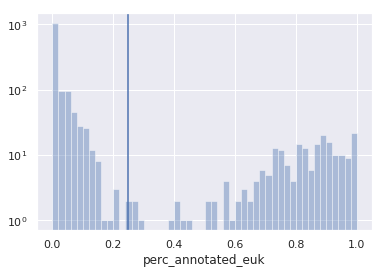

In [24]:
# plot and filter
sns.distplot(bpiv["perc_annotated_euk"], kde=False, bins=50)
plt.axvline(0.25)
plt.yscale("log")

In [71]:
# write out filtered names
bpiv.query("perc_annotated_euk<0.25")["scaffold"].to_csv(rootdir + \
    "viral/genomes/checkv_genomes_50kb_filtered.txt", header=None, index=False)
bpiv["putative_euk_virus"] = bpiv["perc_annotated_euk"].apply(lambda x: x >= 0.25)

Then pullseq from fna to create new.

### dereplicate

In [1253]:
cmdir(rootdir + "viral/drep")

In [1252]:
# create split files
cmdir(rootdir + "viral/genomes/checkv_genomes_50kb_filtered/")

for record in SeqIO.parse(open(rootdir + "viral/genomes/checkv_genomes_50kb_filtered.fna"), "fasta"):
    with open(rootdir + "viral/genomes/checkv_genomes_50kb_filtered/" + record.description.split(" ")[0] + ".fna", "w") as out:
        out.write(">%s\n%s\n" %(record.description.split(" ")[0], str(record.seq)))

In [1181]:
call = "sbatch --wrap 'dRep cluster -g %s -p 48 -pa 0.80 -sa 0.95 --clusterAlg single %s'" %(rootdir + \
    "viral/genomes/checkv_genomes_50kb_filtered/*", rootdir + "viral/drep")
print(call)
call2 = "dRep analyze %s -pl 2" %(rootdir + "viral/drep")
print(call2)

sbatch --wrap 'dRep cluster -g /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/checkv_genomes_50kb_filtered/* -p 48 -pa 0.80 -sa 0.95 --clusterAlg single /groups/banfield/projects/environmental/LacPavin/analysis/viral/drep'
dRep analyze /groups/banfield/projects/environmental/LacPavin/analysis/viral/drep -pl 2


In [27]:
# select representatives
vclust = pd.read_csv(rootdir + "viral/drep/data_tables/Cdb.csv")
# get all scaflens
vlens = {key: len(item) for key, item in {**full_seq_dict, **pro_seq_dict}.items()}
vclust["scaffold"] = vclust["genome"].apply(lambda x: x.replace(".fna", ""))
vclust["viral_region_length"] = vclust["scaffold"].map(vlens)
# define representatives as longest sequence
reps = vclust.sort_values(["secondary_cluster", "viral_region_length"], ascending=[True,False]).drop_duplicates("secondary_cluster")["scaffold"].to_list()
vclust["representative"] = vclust["scaffold"].apply(lambda x: x in reps)
vclustsub = vclust[["scaffold", "primary_cluster", "secondary_cluster", "viral_region_length", "representative"]].sort_values("secondary_cluster")
vclustsub.head()

,scaffold,primary_cluster,secondary_cluster,viral_region_length,representative
155,LacPavin_0818_WC50_scaffold_87984,100,100_1,79155,False
154,LacPavin_0818_WC40_scaffold_224627,100,100_1,131977,True
157,LacPavin_0818_WC45_scaffold_91954,101,101_1,179571,True
156,LacPavin_0818_WC40_scaffold_209120,101,101_1,179480,False
158,LacPavin_0818_WC40_scaffold_736353,102,102_0,60858,True


# finalize

### merge + curate

In [1258]:
cmdir(rootdir + "viral/metadata")

In [72]:
# merge back all info
final_merge = vmerge.merge(bpiv[["scaffold", "putative_euk_virus"]], on="scaffold",how="left")
final_merge = final_merge.merge(vclustsub, how="left", on="scaffold").fillna("None")
final_merge.head()

,scaffold,sample,source,scaffold_length,provirus,proviral_length,gene_count,viral_genes,host_genes,checkv_quality,...,contamination,kmer_freq,warnings,host_virus_ratio,category,putative_euk_virus,primary_cluster,secondary_cluster,viral_region_length,representative
0,LacPavin_0419_WC53_scaffold_20050,LacPavin_0419_WC53,both,32549,No,None,48,2,1,Medium-quality,...,0.0,1.0,None,0.5,unknown:length,None,None,None,None,None
1,LacPavin_0818_WC55_scaffold_109062,LacPavin_0818_WC55,both,12965,No,None,15,10,0,Low-quality,...,0.0,1.0,None,0.0,unknown:length,None,None,None,None,None
2,LacPavin_0818_WC40_scaffold_137667,LacPavin_0818_WC40,both,10302,No,None,29,6,0,Low-quality,...,0.0,1.0,None,0.0,unknown:length,None,None,None,None,None
3,LacPavin_0419_WC70S_scaffold_385877,LacPavin_0419_WC70S,virsorter,25654,No,None,32,3,1,Medium-quality,...,0.0,1.0,None,0.333333,unknown:length,None,None,None,None,None
4,LacPavin_0419_WC70S_scaffold_1098789,LacPavin_0419_WC70S,both,16286,No,None,18,5,0,Low-quality,...,0.0,1.0,None,0.0,unknown:length,None,None,None,None,None


In [1259]:
# manual curation out
final_merge[(final_merge["category"]=="curate") & (final_merge["representative"]==True)].to_csv(rootdir + "viral/metadata/curate_in.tsv", sep="\t", index=False)

In [73]:
# manual curation in
curation_results = pd.read_csv(rootdir + "viral/metadata/curate_out.tsv", sep="\t")
final_merge = final_merge.merge(curation_results[["scaffold", "manual"]], how="left", on="scaffold").fillna("None")

### dereplicate again

In [1508]:
cmdir(rootdir + "viral/drep2")
cmdir(rootdir + "viral/genomes/checkv_genomes_50kb_curated/")

In [1510]:
for key, row in final_merge.query("representative!='None'").iterrows():
    
    with open(rootdir + "viral/genomes/checkv_genomes_50kb_curated/" + row["scaffold"] + ".fna", "w") as out:
  
        if (row["category"] == "provirus:checkv") or (row["manual"]=="provirus:manual"):
            sequence = pro_seq_dict[row["scaffold"]]
        else: sequence = full_seq_dict[row["scaffold"]]

        out.write(">%s\n%s\n" %(row["scaffold"], sequence))

In [1513]:
call = "sbatch --wrap 'dRep cluster -g %s -p 48 -pa 0.80 -sa 0.95 --clusterAlg single %s'" %(rootdir + \
    "viral/genomes/checkv_genomes_50kb_curated/*", rootdir + "viral/drep2")
print(call)

sbatch --wrap 'dRep cluster -g /groups/banfield/projects/environmental/LacPavin/analysis/viral/genomes/checkv_genomes_50kb_curated/* -p 48 -pa 0.80 -sa 0.95 --clusterAlg single /groups/banfield/projects/environmental/LacPavin/analysis/viral/drep2'


In [74]:
# select representatives
reclust = pd.read_csv(rootdir + "viral/drep2/data_tables/Cdb.csv")
# get all scaflens
reclust["scaffold"] = reclust["genome"].apply(lambda x: x.replace(".fna", ""))
reclust["viral_region_length"] = reclust["scaffold"].map(vlens)
# define representatives as longest sequence
reps = reclust.sort_values(["secondary_cluster", "viral_region_length"], ascending=[True,False]).drop_duplicates("secondary_cluster")["scaffold"].to_list()
reclust["representative"] = reclust["scaffold"].apply(lambda x: x in reps)
reclust_dict = {row["scaffold"]: row["representative"] for key, row in reclust.iterrows()}
# merge back in
final_merge["reclust"] = final_merge["scaffold"].apply(lambda x: reclust_dict[x] if x in list(reclust_dict.keys()) else "None")

In [75]:
final_merge[final_merge["representative"]!=final_merge["reclust"]]

,scaffold,sample,source,scaffold_length,provirus,proviral_length,gene_count,viral_genes,host_genes,checkv_quality,...,warnings,host_virus_ratio,category,putative_euk_virus,primary_cluster,secondary_cluster,viral_region_length,representative,manual,reclust


No differences, so okay to leave as is for now.

### create metadata

In [80]:
# final
fmeta = defaultdict(list)

for key, row in final_merge.iterrows():
    
    # to maintain
    for item in ["scaffold", "sample", "source"]:
        fmeta[item].append(row[item])
    
    # final category
    if (row["category"] == "curate") & (row["representative"]==False):
        # get representative sequence
        rep = final_merge[(final_merge["secondary_cluster"]==row["secondary_cluster"]) & \
            (final_merge["representative"]==True)]["scaffold"].iloc[0]
        # if representative was automated
        if final_merge[final_merge["scaffold"]==rep]["manual"].iloc[0] == "None":
            ccat = final_merge[final_merge["scaffold"]==rep]["category"].iloc[0]
        else: ccat = final_merge[final_merge["scaffold"]==rep]["manual"].iloc[0]
        
    elif row["category"] == "curate":
        ccat = row["manual"]
    else: ccat = row["category"]
    
    fmeta["curated_category"].append(ccat)
    fmeta["scaffold_length"].append(row["scaffold_length"])
    
    if "provirus" in ccat:
        fmeta["region_length"].append(row["viral_region_length"])
    else: fmeta["region_length"].append(row["scaffold_length"])
    
    for item in ["putative_euk_virus", "primary_cluster", "secondary_cluster", "representative"]:
        fmeta[item].append(row[item])
        
    # circularization
    if row["completeness_method"] == "DTR (high-confidence)":
        fmeta["circularized"].append(True)
    else: fmeta["circularized"].append(False)
        
fmetadf = pd.DataFrame(fmeta)

In [81]:
# all
fmetadf.to_csv(rootdir + "viral/metadata/curated_viral_metadata_all.tsv", sep="\t", index=False)
# subset
subset = fmetadf[(fmetadf["curated_category"]).str.contains("virus") & (fmetadf["putative_euk_virus"]==False) & \
        (fmetadf["representative"]==True)]
subset.to_csv(rootdir + "viral/metadata/curated_viral_metadata_subset.tsv", sep="\t", index=False)

### write out sequences

In [1532]:
cmdir(rootdir + "viral/genomes/final_genomes/")

In [1544]:
for genome in glob.glob(rootdir + "viral/genomes/checkv_genomes_50kb_curated/*"):
    
    name = os.path.basename(genome).split(".")[0]
    
    if name in list(subset["scaffold"].unique()):
        sp.call("cp %s %s" %(genome, rootdir + "viral/genomes/final_genomes/"), shell=True)